In [1]:
import drjit as dr
import mitsuba as mi
import os

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np

mi.set_variant('cuda_ad_rgb')

from mitsuba.scalar_rgb import Transform4f as T
from utils.lie_mi import *
from utils.optimizer import *
from utils.vis_utils import *

import integrator.camera_direct

## Scene

In [57]:
def init_scene(spp):
    scene_dict = mi.cornell_box()
    scene_dict['integrator'] = {'type': 'camera_direct'}
    scene = mi.load_dict(scene_dict)

    params = mi.traverse(scene)
    img_ref = mi.render(scene, seed=0, spp = spp)
    return scene, params, img_ref

# T + R

## Reference image

In [4]:
spp = 1024*8

In [5]:
scene, params, img_ref = init_scene(spp)
mi.util.convert_to_bitmap(img_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

## Optimizer and Parameterization

Transformation settings

In [6]:
sensor_to_world = params['sensor.to_world']

Translation = mi.Point3f(0.1,0.03,-0.02)
Rotation = mi.Vector3f(0.01,0.02,0.05)
disturb = mi.Transform4f.translate(Translation) @ mi.Matrix4f(so3_to_SO3(w_to_wx(Rotation)))
init_state = disturb @ sensor_to_world

Define transformation function

In [7]:
def apply_transformation(params, opt):

    trafo = se3_to_SE3(opt['w'],opt['u'])
    
    params['sensor.to_world'] = trafo
    params.update()

Define optimizer

In [8]:
opt = R_Adam(lr=0.05,mode = 1)
wu = SE3_to_se3(init_state.matrix)
opt['w'] = mi.Point3f(wu[0],wu[1],wu[2])
opt['u'] = mi.Point3f(wu[3],wu[4],wu[5])
iteration_count = 20

In [9]:
with dr.suspend_grad():
    apply_transformation(params, opt)
    img_init = mi.render(scene, seed=0, spp=spp)
mi.util.convert_to_bitmap(img_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

In [10]:
loss_hist = []
lt = []
lr = []
record_p = []
record_r = []

for it in range(iteration_count):

    # Apply the mesh transformation 
    with dr.suspend_grad():
        record_r.append(mi.Matrix3f(se3_to_SE3(opt['w'],opt['u']).matrix))
        record_p.append([se3_to_SE3(opt['w'],opt['u']).translation().x[0],se3_to_SE3(opt['w'],opt['u']).translation().y[0],se3_to_SE3(opt['w'],opt['u']).translation().z[0]])

    apply_transformation(params, opt)

    with dr.suspend_grad():
        lt.append(dr.sum(dr.sqr(params['sensor.to_world'].translation() - sensor_to_world.translation())))
        lr.append(dr.sum(dr.sum(dr.unravel(mi.Matrix3f, dr.sqr(dr.ravel(mi.Matrix3f(params['sensor.to_world'].matrix - sensor_to_world.matrix)))))))
    
    # Perform a differentiable rendering
    img = mi.render(scene, params, seed=it, spp=spp)

    # Evaluate the objective function
    loss = dr.sum(dr.sqr(img - img_ref)) / len(img)

    # Backpropagate through the rendering process
    dr.backward(loss)
    # print(dr.grad(opt['angle']))

    # Optimizer: take a gradient descent step
    opt.step()

    loss_hist.append(loss)
    
    print(f"Iteration {it:02d}: error={loss[0]:6f}", end='\r')



Text(0.5, 1.0, 'Optimized image')

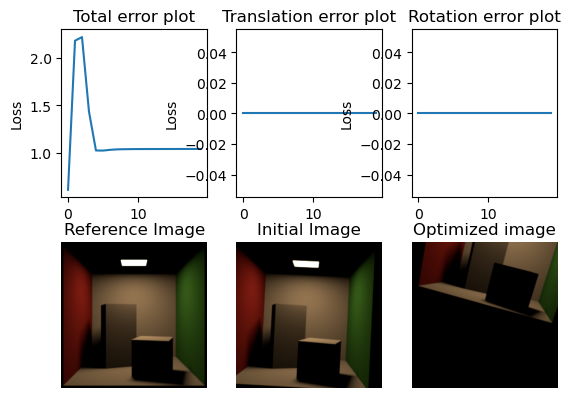

In [40]:
fig, axs = plt.subplots(2,3)

axs[0][0].plot(loss_hist)
# axs[0][0].set_xlabel('iteration'); 
axs[0][0].set_ylabel('Loss'); 
axs[0][0].set_title('Total error plot');


axs[0][1].plot(lt)
# axs[0][1].set_xlabel('iteration'); 
axs[0][1].set_ylabel('Loss'); 
axs[0][1].set_title('Translation error plot');


axs[0][2].plot(lr)
# axs[0][2].set_xlabel('iteration'); 
axs[0][2].set_ylabel('Loss'); 
axs[0][2].set_title('Rotation error plot');


axs[1][0].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1][0].axis('off')
axs[1][0].set_title('Reference Image')

axs[1][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[1][1].axis('off')
axs[1][1].set_title('Initial Image')

axs[1][2].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=1024)))
axs[1][2].axis('off')
axs[1][2].set_title('Optimized image')

# Translation Only

## Reference image

In [58]:
spp = 1024*8

In [59]:
scene, params, img_ref = init_scene(spp)
mi.util.convert_to_bitmap(img_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

## Optimizer and Parameterization

Transformation settings

In [44]:
sensor_to_world = params['sensor.to_world']

Translation = mi.Point3f(0.12,0.04,-0.05)
# Rotation = mi.Vector3f(0.01,0.02,0.05)
disturb = mi.Transform4f.translate(Translation)
init_state = disturb @ sensor_to_world

Define transformation function

In [45]:
def apply_transformation(params, opt):

    trafo = mi.Transform4f.translate(opt['T']) @ init_state
    
    params['sensor.to_world'] = trafo
    params.update()

Define optimizer

In [46]:
opt = R_Adam(lr=0.05,mode = 1)
opt['T'] = mi.Point3f(0,0,0)
iteration_count = 20

In [47]:
with dr.suspend_grad():
    apply_transformation(params, opt)
    img_init = mi.render(scene, seed=0, spp=spp)
mi.util.convert_to_bitmap(img_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

In [49]:
loss_hist = []
lt = []
lr = []
record_p = []
record_r = []

for it in range(iteration_count):

    apply_transformation(params, opt)

    with dr.suspend_grad():
        lt.append(dr.sum(dr.sqr(params['sensor.to_world'].translation() - sensor_to_world.translation())))
        # lr.append(dr.sum(dr.sum(dr.unravel(mi.Matrix3f, dr.sqr(dr.ravel(mi.Matrix3f(params['sensor.to_world'].matrix - sensor_to_world.matrix)))))))
    
    # Perform a differentiable rendering
    img = mi.render(scene, params, seed=it, spp=spp)

    # Evaluate the objective function
    loss = dr.sum(dr.sqr(img - img_ref)) / len(img)

    # Backpropagate through the rendering process
    dr.backward(loss)
    # print(dr.grad(opt['angle']))

    # Optimizer: take a gradient descent step
    opt.step()

    loss_hist.append(loss)
    
    print(f"Iteration {it:02d}: error={loss[0]:6f}", end='\r')



Text(0.5, 1.0, 'Optimized image')

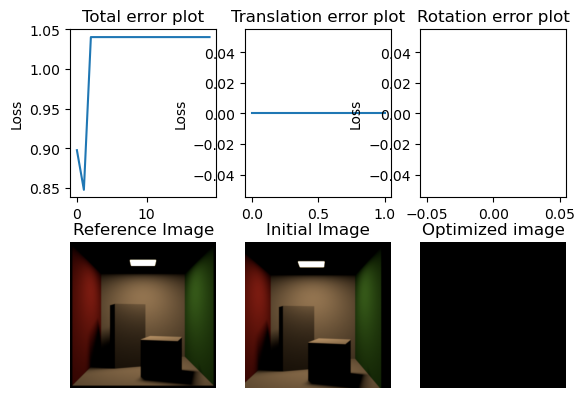

In [50]:
fig, axs = plt.subplots(2,3)

axs[0][0].plot(loss_hist)
# axs[0][0].set_xlabel('iteration'); 
axs[0][0].set_ylabel('Loss'); 
axs[0][0].set_title('Total error plot');


axs[0][1].plot(lt)
# axs[0][1].set_xlabel('iteration'); 
axs[0][1].set_ylabel('Loss'); 
axs[0][1].set_title('Translation error plot');


axs[0][2].plot(lr)
# axs[0][2].set_xlabel('iteration'); 
axs[0][2].set_ylabel('Loss'); 
axs[0][2].set_title('Rotation error plot');


axs[1][0].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1][0].axis('off')
axs[1][0].set_title('Reference Image')

axs[1][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[1][1].axis('off')
axs[1][1].set_title('Initial Image')

axs[1][2].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=1024)))
axs[1][2].axis('off')
axs[1][2].set_title('Optimized image')